In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn import cluster, metrics

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data_path = '../../data/cleaned/UCB_dept_merge.csv'

### Modified data
The first step was to select a subset of useful columns, and do some early data processing to have a reasonable data set.

In [4]:
# Parsing date columns allows us to do some nifty things with pandas
date_columns = ['po_closed_date', 'creation_date']

In [5]:
data = pd.read_csv(data_path, parse_dates=date_columns)

In [6]:
data['cost_total'] = data.unit_price * data.quantity

# Time analysis

In [7]:
groupby = ['creation_date', 'supplier_name']
# groupby = ['creation_date', 'department_name']
# groupby = ['creation_date', 'manufacturer']

# week_counts = data.groupby(groupby).count() # Number of POs per department
week_counts = data.groupby(groupby).mean() # Mean/med cost per department

week_counts = week_counts['cost_total'].unstack(groupby[-1])\
    .resample('w', how='sum')
week_counts['week'] = week_counts.index.week

In [8]:
week_sums = week_counts.groupby('week').sum().replace(np.nan, 0)
week_mean = week_sums.mean(1)
week_ste = week_sums.std(1) / np.sqrt((week_sums != 0).sum(1))

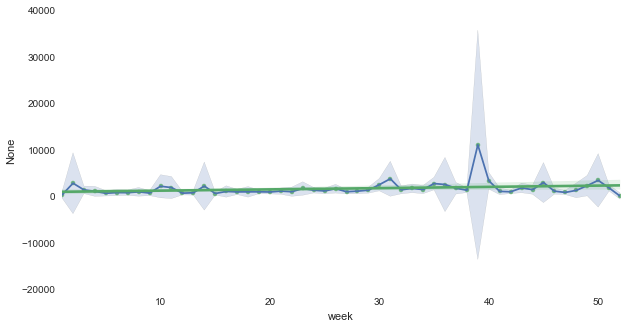

In [9]:
ax = week_mean.plot(figsize=(10, 5))
ax.fill_between(week_ste.index, week_mean-week_ste, week_mean+week_ste,
                alpha=.2)
sns.regplot(week_mean.index.values, week_mean, ax=ax)

In [10]:
def sort_column(arr):
    """Sort a column by its values."""
    ix_sort = np.argsort(arr.values)
    return arr.iloc[ix_sort[::-1]].values

In [11]:
# Similarities in time for depts
null_cut = 2 # Keep depts with less than this # null counts
keep_cols = (week_sums == 0).sum(0) < null_cut
week_sums_active = week_sums.loc[:, keep_cols]
week_sums_normalized = week_sums_active / week_sums_active.sum(0)
week_sums_normalized_ordered = week_sums_normalized.apply(sort_column) 

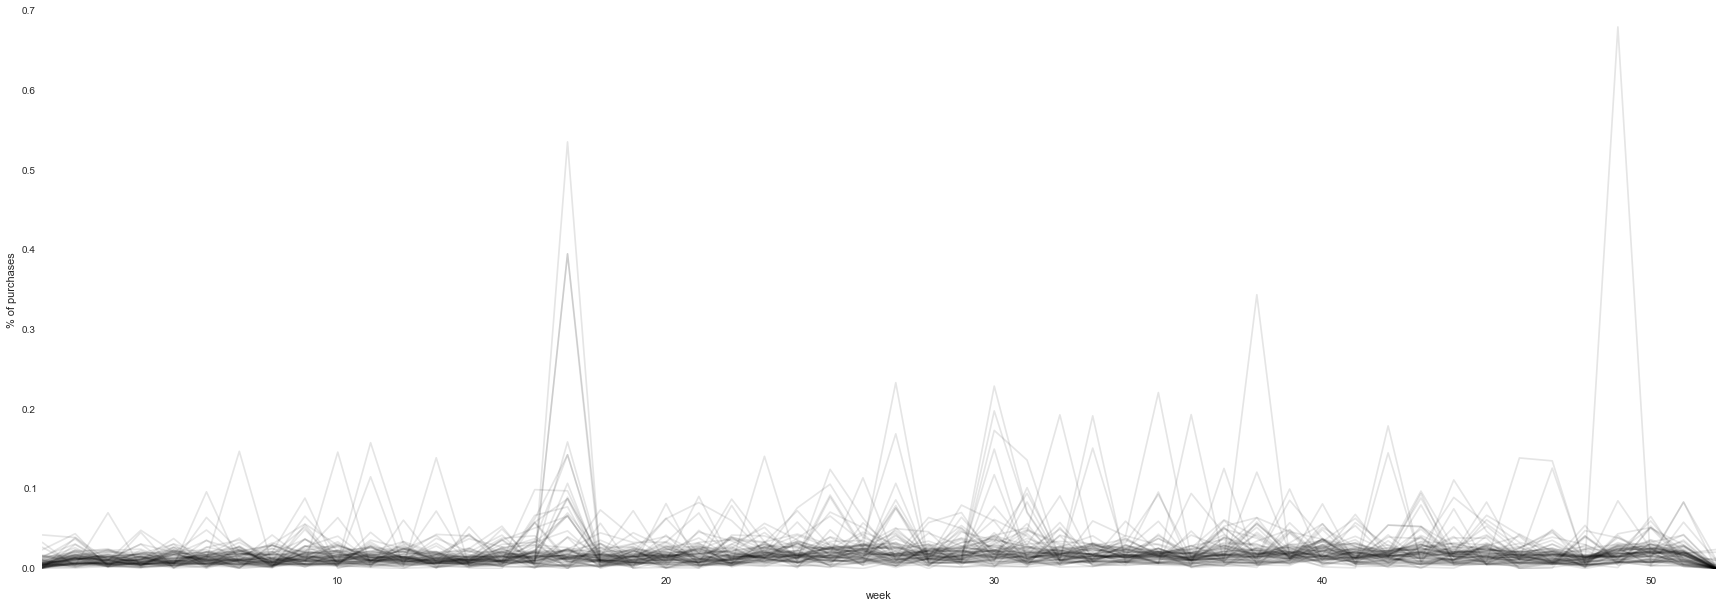

In [29]:
ax = week_sums_normalized.plot(legend=False, c='k', alpha=.1, figsize=(30, 10))
ax.figure.patch.set_color('w')
ax.set_ylabel('% of purchases')

In [ ]:
order

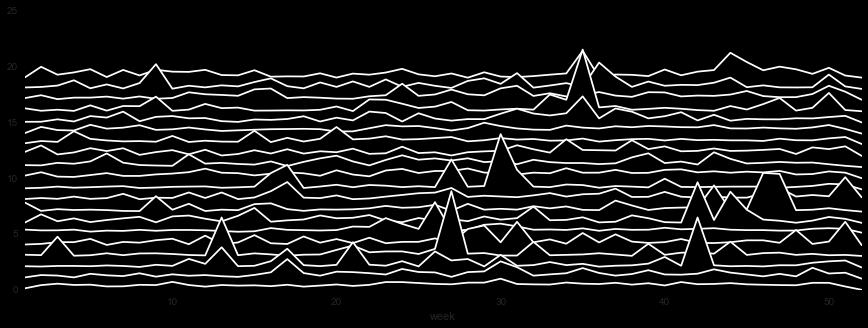

In [64]:
f, ax = plt.subplots(figsize=(15, 5))
plt_weeks = 20
orders = np.arange(plt_weeks)[::-1]
for i, ((col, row), order) in enumerate(zip(week_sums_normalized.iloc[:, :plt_weeks].iteritems(), orders)):
    row.mul(25).add(i).plot(ax=ax, c='w')
    ax.lines[-1].set_zorder(order)
    fill = ax.fill_between(row.index, 0, row.mul(25).add(i), facecolor='k')
    fill.set_zorder(order)
ax.figure.patch.set_color('k')
ax.grid(False)

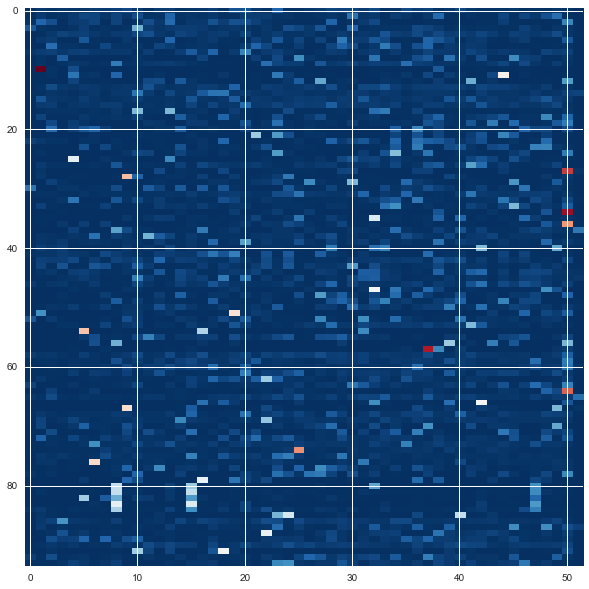

In [76]:
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(week_sums_normalized.T, cmap=plt.cm.RdBu_r,
          aspect='auto', interpolation='nearest')

In [77]:
clust = cluster.KMeans(n_clusters=10)
# clust = cluster.AffinityPropagation()
# clust = cluster.SpectralClustering()
# clust = cluster.AgglomerativeClustering(n_clusters=20)

In [78]:
keep_weeks = 10
# X = week_sums_normalized.T.values
# X = week_sums_active.T.values
X = week_sums_normalized_ordered.T.values[:, :keep_weeks]
try:
    clust.fit(X)
    labels = clust.predict(X)
except:
    labels = clust.fit_predict(X)

In [79]:
labels_df = pd.DataFrame(labels, columns=['label']).astype(str)
labels_df['id'] = 1

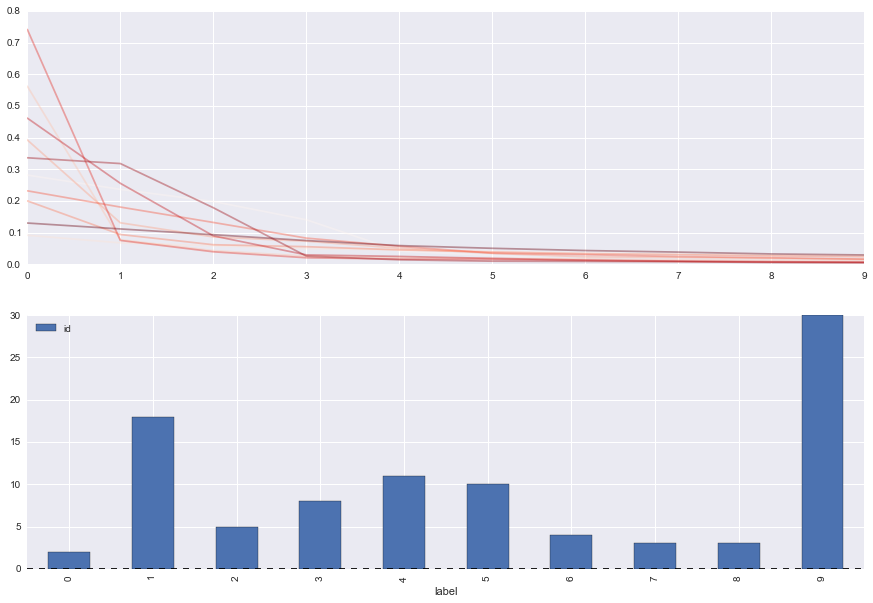

In [80]:
f, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10))
col_plt = plt.cm.Reds(np.linspace(0, 1, clust.cluster_centers_.shape[0]))
ax.set_color_cycle(col_plt)
_ = ax.plot(clust.cluster_centers_.T, alpha=.4)

_ = labels_df.groupby('label').count().plot(kind='bar', ax=ax2)

In [81]:
sil = metrics.silhouette_score(X, labels)
print sil

0.342004767446


In [82]:
def inspect_clust(clust, ax, col):
    n_week, n_sig = clust.shape
    clust_mean = clust.mean(1)
    clust_ste = clust.std(1) / np.sqrt(n_sig)

    _ = ax.plot(clust, alpha=.5, color=col(.5))
    _ = ax.plot(clust_mean, color='k')
    _ = ax.fill_between(range(n_week), 
                        clust_mean - clust_ste, clust_mean + clust_ste,
                        alpha=.5, color='k')

In [83]:
cols = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greens]

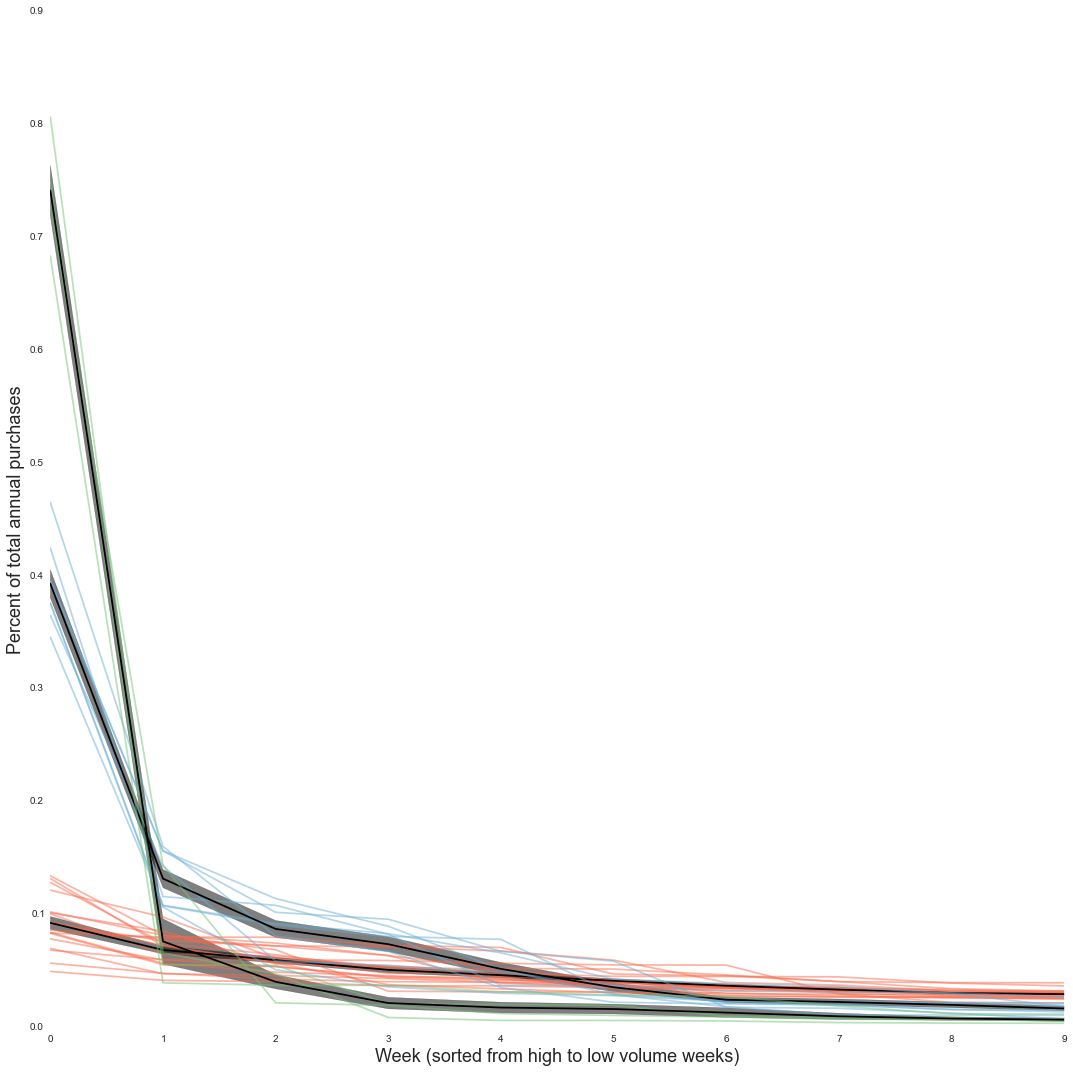

In [84]:
label_dict = dict(fontsize=18)
plt_clusts = [1, 3, 6]
f, ax = plt.subplots(figsize=(15, 15))
for plt_clust, col in zip(plt_clusts, cols):
    mask_clust = labels == plt_clust
    X_sub = X[mask_clust, :].T
    names_clust = week_sums_normalized.columns[mask_clust]
    inspect_clust(X_sub, ax, col)
#     ax.set_title(names_clust.values)
ax.set_xlabel('Week (sorted from high to low volume weeks)', **label_dict)
ax.set_ylabel('Percent of total annual purchases', **label_dict)
ax.grid(False)
ax.patch.set_visible(False)
plt.tight_layout()


In [163]:
f.savefig('../../results/clustering_summary.pdf')

## Correlation matrix

In [92]:
week_sums_corr = week_sums_normalized.corr()
# week_sums_corr = week_sums_normalized_ordered.corr()

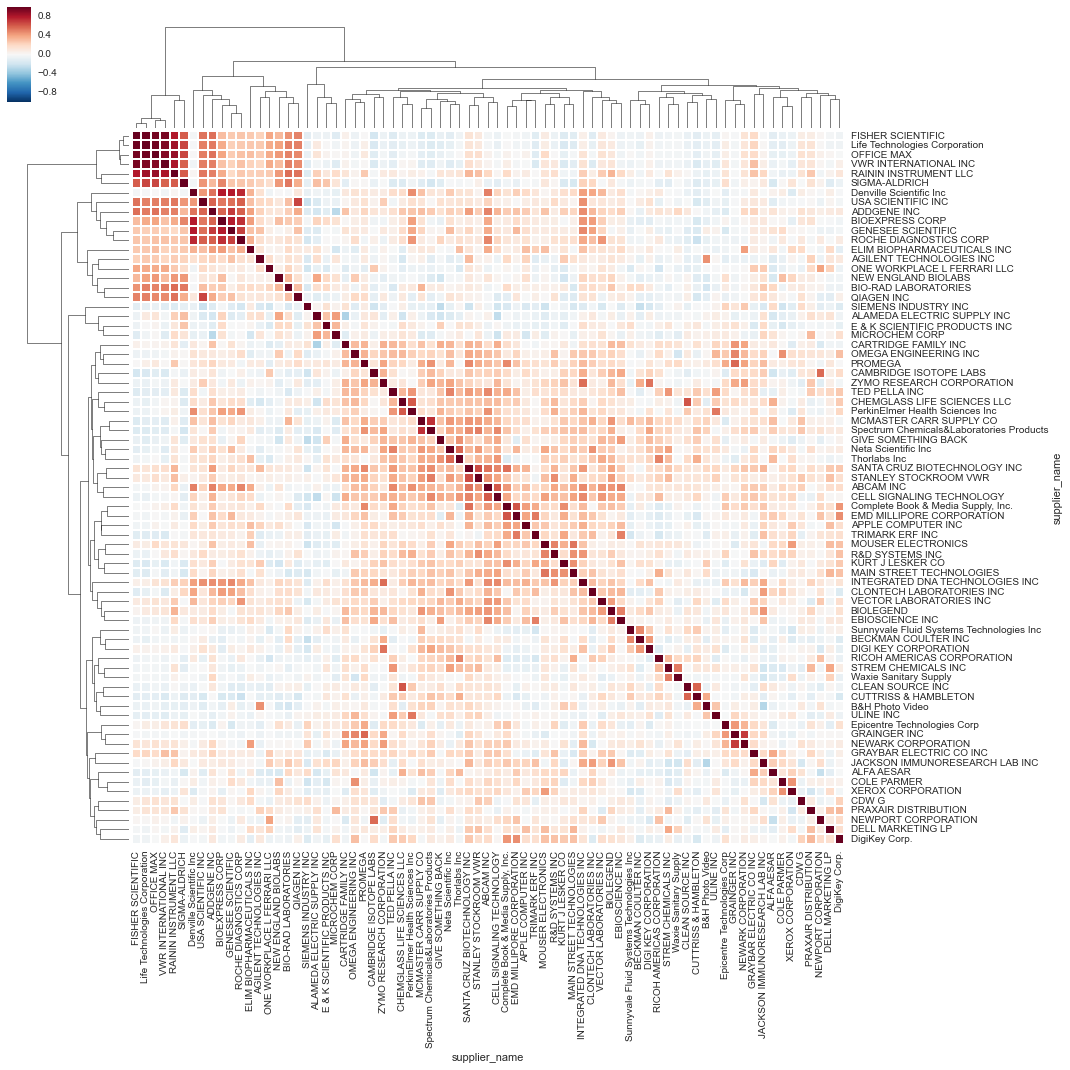

In [93]:
clust = sns.clustermap(week_sums_corr, figsize=(15, 15))